# F21MP Emotion Recognition System

#Aim & Objectives
The aim of this project is the development of a fully working emotion recognition software which can detect the face of the person and recognize any of the 7 emotions (happy, angry, sad, surprised, fear, disgust or neutral) shown by the user.

The current solution and best practices for emotion recognition will be analyzed, a prototype emotion recognition software will be developed using VGG16 and potential users will evaluate this software.

#Project Design

Import all the important libraries required to initialize all the variables.

In [1]:
#importing the required libraries
import pandas as pd
from matplotlib import pyplot
from math import sqrt 
import numpy as np 
import scipy.misc 
from IPython.display import display 
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from tensorflow.keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline
emdata=pd.read_csv('/content/drive/MyDrive/fer2013.csv') #assigning the dataset to a variable
emdata.head() #displaying first 5 rows of the dataset 

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10 #changing size of figure

In [3]:
emdata.emotion.value_counts() #displaying the number of data for every emotions

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [4]:
#assigning lables for the numbers 0-6
num_classes = 7
width = 48
height = 48
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
classes=np.array(("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"))

In [5]:
emdata.Usage.value_counts() 

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

Assigning pixels and emotions to X list and Y list


In [6]:
train_set = emdata[(emdata.Usage == 'Training')] 
val_set = emdata[(emdata.Usage == 'PublicTest')]
test_set = emdata[(emdata.Usage == 'PrivateTest')] 
# assigning pixels to X variables 
X_train = np.array(list(map(str.split, train_set.pixels)), np.float32) 
X_val = np.array(list(map(str.split, val_set.pixels)), np.float32)  #converting the pixels into float
X_test = np.array(list(map(str.split, test_set.pixels)), np.float32) 
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1) 
X_val = X_val.reshape(X_val.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

In [7]:
num_train = X_train.shape[0]
num_val = X_val.shape[0]
num_test = X_test.shape[0]

In [8]:
# assigning emotions to y variables
y_train = train_set.emotion 
y_train = np_utils.to_categorical(y_train, num_classes) 
y_val = val_set.emotion 
y_val = np_utils.to_categorical(y_val, num_classes) 
y_test = test_set.emotion 
y_test = np_utils.to_categorical(y_test, num_classes) 

Image Data Augmentation is used.

Adding data augmentation to enhance the volume of data by adding slightly changed copies of currently existing data. It serves as a regularizer and aids in lowering overfitting while a machine learning model is being trained

In [9]:
#Image Augmentation for Facial Emotion Detection
datagen = ImageDataGenerator( 
    rescale=1./255,
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest')

testgen = ImageDataGenerator( 
    rescale=1./255
    )
datagen.fit(X_train)
batch_size = 64

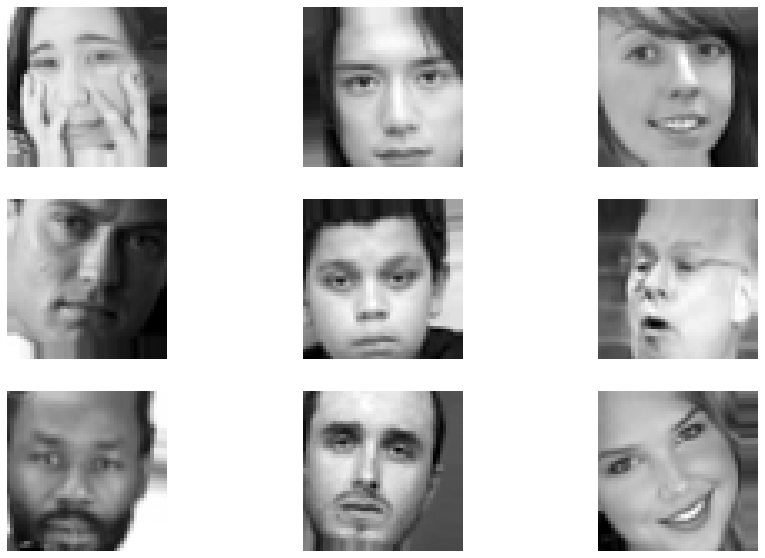

In [10]:
#applying some data augmentation before passing it to model 
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    for i in range(0, 9): 
        pyplot.axis('off') 
        pyplot.subplot(330 + 1 + i) 
        pyplot.imshow(X_batch[i].reshape(48, 48), cmap=pyplot.get_cmap('gray'))
    pyplot.axis('off') 
    pyplot.show() 
    break 

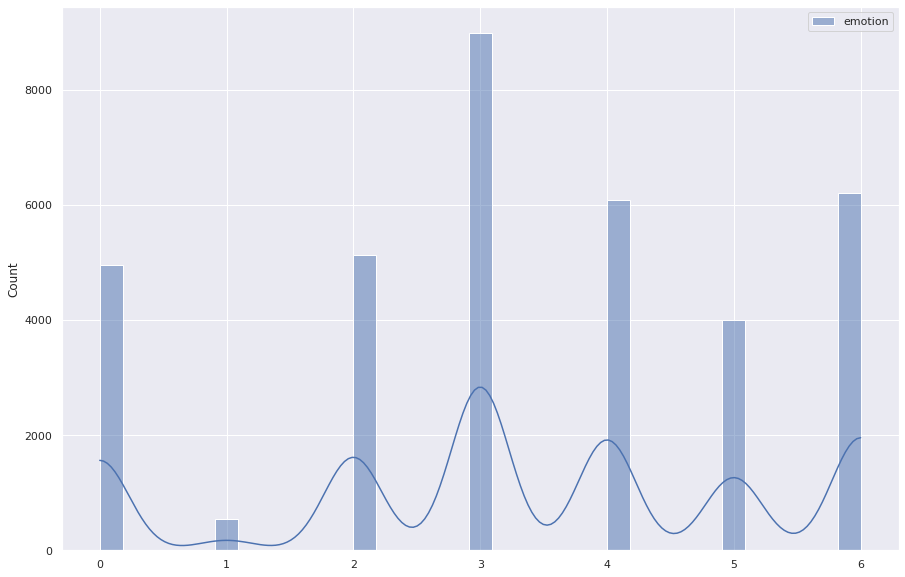

In [11]:
#Plotting number of data for the 7 categories
import seaborn as sns
sns.set_theme(style='darkgrid', palette='deep', font='sans-serif', font_scale=1)
sns.histplot(data= emdata,kde = True)

From the graph above we see that happy has the most data of around 8000 data and disgust has the least amount of data of around 1000 data.

In [12]:
#fitting data to the image generator
train_flow = datagen.flow(X_train, y_train, batch_size=batch_size) 
val_flow = testgen.flow(X_val, y_val, batch_size=batch_size) 
test_flow = testgen.flow(X_test, y_test, batch_size=batch_size) 

#VGG-16 Model Implementation

To perform learning effectively, the model is first initialized, then a batch normalization layer is added, and then various layers using ReLu as an activation function, max pool layers, and dropouts. We compile the model using Adam as an optimizer, loss as categorical cross-entropy, and metrics as accuracy.

In [13]:
# building the model and defining the architecture of the model
def FER_Model(input_shape=(48,48,1)):
    # first input model
    visible = Input(shape=input_shape, name='input')
    num_classes = 7
    #creating blocks using conv2D
    #the 1-st block
    conv1_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_1')(visible)
    conv1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_2')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)
    pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1')(conv1_2)
    drop1_1 = Dropout(0.3, name = 'drop1_1')(pool1_1)

    #the 2-nd block
    conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_1')(drop1_1)
    conv2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_2')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)
    conv2_3 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_3')(conv2_2)
    conv2_2 = BatchNormalization()(conv2_3)
    pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_3)
    drop2_1 = Dropout(0.3, name = 'drop2_1')(pool2_1)

    #the 3-rd block
    conv3_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_1')(drop2_1)
    conv3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_2')(conv3_1)
    conv3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_3')(conv3_2)
    conv3_3 = BatchNormalization()(conv3_3)
    conv3_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_4')(conv3_3)
    conv3_4 = BatchNormalization()(conv3_4)
    pool3_1 = MaxPooling2D(pool_size=(2,2), name = 'pool3_1')(conv3_4)
    drop3_1 = Dropout(0.3, name = 'drop3_1')(pool3_1)

    #the 4-th block
    conv4_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_1')(drop3_1)
    conv4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_2')(conv4_1)
    conv4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_3')(conv4_2)
    conv4_3 = BatchNormalization()(conv4_3)
    conv4_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_4')(conv4_3)
    conv4_4 = BatchNormalization()(conv4_4)
    pool4_1 = MaxPooling2D(pool_size=(2,2), name = 'pool4_1')(conv4_4)
    drop4_1 = Dropout(0.3, name = 'drop4_1')(pool4_1)

    #the 5-th block
    conv5_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_1')(drop4_1)
    conv5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_2')(conv5_1)
    conv5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_3')(conv5_2)
    conv5_3 = BatchNormalization()(conv5_3)
    conv5_4 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_4')(conv5_3)
    conv5_3 = BatchNormalization()(conv5_3)
    pool5_1 = MaxPooling2D(pool_size=(2,2), name = 'pool5_1')(conv5_4)
    drop5_1 = Dropout(0.3, name = 'drop5_1')(pool5_1)

    #Flatten and output
    flatten = Flatten(name = 'flatten')(drop5_1)
    ouput = Dense(num_classes, activation='softmax', name = 'output')(flatten)

    # create model 
    model = Model(inputs =visible, outputs = ouput)
    # summary layers
    print(model.summary())
    
    return model

In [14]:
#Compiling model using Adam optimizer
model = FER_Model()
opt = Adam(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 1)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv1_2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 pool1_1 (MaxPooling2D)      (None, 24, 24, 64)        0     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


We are training the model by iterating 100 times over the entire training set with 100 epochs.

In [15]:
#training the model
num_epochs = 100 # we iterate 100 times over the entire training set 
history = model.fit_generator(train_flow, 
                    steps_per_epoch=len(X_train) / batch_size, 
                    epochs=num_epochs,  
                    verbose=2,  
                    validation_data=val_flow,  
                    validation_steps=len(X_val) / batch_size) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
448/448 - 46s - loss: 2.0306 - accuracy: 0.2154 - val_loss: 1.9008 - val_accuracy: 0.1800 - 46s/epoch - 102ms/step
Epoch 2/100
448/448 - 31s - loss: 1.7886 - accuracy: 0.2502 - val_loss: 1.8167 - val_accuracy: 0.2566 - 31s/epoch - 69ms/step
Epoch 3/100
448/448 - 32s - loss: 1.7547 - accuracy: 0.2738 - val_loss: 1.7562 - val_accuracy: 0.2875 - 32s/epoch - 71ms/step
Epoch 4/100
448/448 - 32s - loss: 1.6996 - accuracy: 0.3153 - val_loss: 2.0740 - val_accuracy: 0.3020 - 32s/epoch - 72ms/step
Epoch 5/100
448/448 - 32s - loss: 1.6337 - accuracy: 0.3519 - val_loss: 1.6703 - val_accuracy: 0.3789 - 32s/epoch - 71ms/step
Epoch 6/100
448/448 - 32s - loss: 1.5747 - accuracy: 0.3791 - val_loss: 1.5322 - val_accuracy: 0.4291 - 32s/epoch - 71ms/step
Epoch 7/100
448/448 - 33s - loss: 1.5025 - accuracy: 0.4173 - val_loss: 1.4390 - val_accuracy: 0.4531 - 33s/epoch - 73ms/step
Epoch 8/100
448/448 - 32s - loss: 1.4324 - accuracy: 0.4441 - val_loss: 1.3655 - val_accuracy: 0.4784 - 32s/epoch - 7

Serialize the model to JSON and save the model weights in an hd5 file so that we can make use of this file to make predictions rather than training the network again

In [16]:
#Saving the model’s architecture into JSON and model’s weight into .h5
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [17]:
loss = model.evaluate(X_test/255., y_test) 
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 3s 15ms/step - loss: 1.3512 - accuracy: 0.6868
Test Acc: 0.6868208646774292


Creating the Loss and Accuracy graph for the VGG-16 model we generated.

<Figure size 432x288 with 0 Axes>

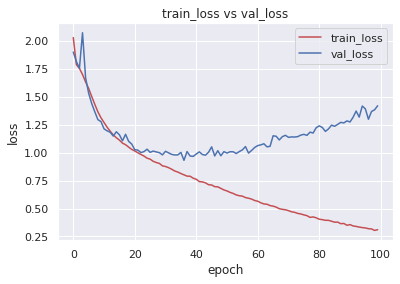

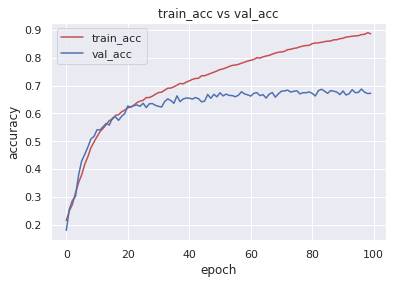

<Figure size 432x288 with 0 Axes>

In [18]:
# visualizing losses and accuracy
%matplotlib inline

train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.figure()

From the graphs above:

The validation loss decreases until a turning point is reached, and then it begins to slowly increase after 20 epochs. The start of overfitting is at that moment.

Validation accuracy is 68.07% and the training accuracy is 88.51%. This means that the model can detect emotion on the training dataset more accurately than the validation or test dataset. 

Confusion matrix for true prediction vs predicted expressions

In [19]:
#making the confusion matrix of true prediction vs predicted expressions
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()
  

In [20]:
y_pred_ = model.predict(X_test/255., verbose=1)
y_pred = np.argmax(y_pred_, axis=1)
t_te = np.argmax(y_test, axis=1)

113/113 [==============================] - 2s 12ms/step


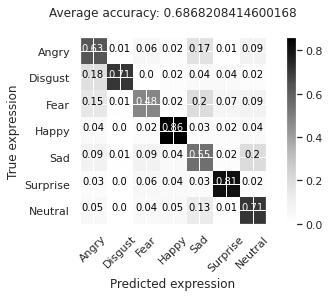

In [21]:
fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      cmap=plt.cm.Greys,
                      title='Average accuracy: ' + str(np.sum(y_pred == t_te)/len(t_te)) + '\n')

#Conclusion

The proposed model with additional implementation of image augmentations, layer dropout and normalization with less complexity achieved a model accuracy of 68.07% validation accuracy at 88.51% training accuracy at 100 epochs.

The model proposed in this project has some overfitting issues which can be improved in two methods. One such method is to use GAP. Another attempt to reduce overfitting possibility is the use of early stopping. Further is explained in the dissertation report attached.